### Генерация поэзии с помощью нейронных сетей: шаг 1
##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), @neychev

Ваша основная задача: научиться генерировать стихи с помощью простой рекуррентной нейронной сети (Vanilla RNN). В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина.

In [1]:
# do not change the code in the block below
# __________start of block__________
import string
import os
from random import sample

import numpy as np
import torch, torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

import matplotlib.pyplot as plt
# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('{} device is available'.format(device))
# __________end of block__________

cuda device is available


#### 1. Загрузка данных.

In [3]:
# do not change the code in the block below
# __________start of block__________
!wget https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()

text = "".join([x.replace('\t\t', '').lower() for x in text])
# __________end of block__________

--2024-11-04 07:58:25--  https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.03s   

2024-11-04 07:58:25 (9.48 MB/s) - ‘onegin.txt’ saved [262521/262521]



#### 2. Построение словаря и предобработка текста
В данном задании требуется построить языковую модель на уровне символов. Приведем весь текст к нижнему регистру и построим словарь из всех символов в доступном корпусе текстов. Также добавим токен `<sos>`.

In [4]:
# do not change the code in the block below
# __________start of block__________
tokens = sorted(set(text.lower())) + ['<sos>']
num_tokens = len(tokens)

assert num_tokens == 84, "Check the tokenization process"

token_to_idx = {x: idx for idx, x in enumerate(tokens)}
idx_to_token = {idx: x for idx, x in enumerate(tokens)}

assert len(tokens) == len(token_to_idx), "Mapping should be unique"

print("Seems fine!")

text_encoded = [token_to_idx[x] for x in text]
# __________end of block__________

Seems fine!


__Ваша задача__: обучить классическую рекуррентную нейронную сеть (Vanilla RNN) предсказывать следующий символ на полученном корпусе текстов и сгенерировать последовательность длины 100 для фиксированной начальной фразы.

Вы можете воспользоваться кодом с занятие №6 или же обратиться к следующим ссылкам:
* Замечательная статья за авторством Andrej Karpathy об использовании RNN: [link](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* Пример char-rnn от Andrej Karpathy: [github repo](https://github.com/karpathy/char-rnn)
* Замечательный пример генерации поэзии Шекспира: [github repo](https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb)

Данное задание является достаточно творческим. Не страшно, если поначалу оно вызывает затруднения. Последняя ссылка в списке выше может быть особенно полезна в данном случае.

Далее для вашего удобства реализована функция, которая генерирует случайный батч размера `batch_size` из строк длиной `seq_length`. Вы можете использовать его при обучении модели.

In [5]:
# do not change the code in the block below
# __________start of block__________
batch_size = 256
seq_length = 100
start_column = np.zeros((batch_size, 1), dtype=int) + token_to_idx['<sos>']

def generate_chunk():
    global text_encoded, start_column, batch_size, seq_length

    start_index = np.random.randint(0, len(text_encoded) - batch_size*seq_length - 1)
    data = np.array(text_encoded[start_index:start_index + batch_size*seq_length]).reshape((batch_size, -1))
    yield np.hstack((start_column, data))
# __________end of block__________

Пример батча:

In [6]:
next(generate_chunk())

array([[83, 38,  0, ..., 48, 59, 47],
       [83, 59, 61, ...,  5,  1, 61],
       [83, 45, 47, ..., 45,  1, 60],
       ...,
       [83, 62, 63, ..., 48, 56, 64],
       [83, 46, 53, ...,  0, 50, 48],
       [83, 59,  1, ...,  1, 60, 53]])

Далее вам предстоит написать код для обучения модели и генерации текста.

In [7]:
class VanillaRNN(nn.Module):
    def __init__(self, num_tokens, hidden_size, num_layers=1):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(num_tokens, hidden_size)
        self.rnn = nn.RNN(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_tokens)

    def forward(self, x, hidden):
        x = self.embedding(x)
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device)

In [8]:
def train(model, num_epochs, batch_size, seq_length, learning_rate):

    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    all_losses = []

    for epoch in range(num_epochs):

        hidden = model.init_hidden(batch_size)

        epoch_loss = 0

        for i, batch in enumerate(generate_chunk()):
            inputs = torch.tensor(batch[:, :-1], dtype=torch.long).to(device)
            targets = torch.tensor(batch[:, 1:], dtype=torch.long).to(device)

            hidden = hidden.detach()  # Обрываем связи с предыдущими градиентами
            model.zero_grad()

            outputs, hidden = model(inputs, hidden)
            loss = criterion(outputs.reshape(-1, num_tokens), targets.reshape(-1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / (i + 1)
        all_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss}")

        clear_output(wait=True)
        plt.grid(True)
        plt.plot(all_losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    print("Training finished")
    return all_losses

В качестве иллюстрации ниже доступен график значений функции потерь, построенный в ходе обучения авторской сети (сам код для ее обучения вам и предстоит написать).

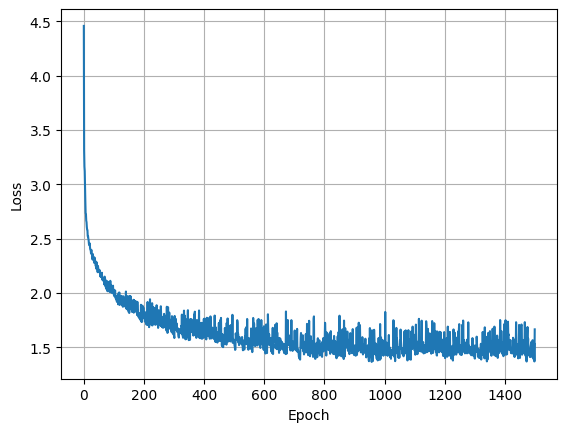

Training finished


In [9]:
hidden_size = 256  # Размер скрытого слоя
num_epochs = 1500  # Количество эпох
learning_rate = 0.01  # Скорость обучения

model = VanillaRNN(num_tokens, hidden_size).to(device)
losses = train(model, num_epochs, batch_size, seq_length, learning_rate)

Шаблон функции `generate_sample` также доступен ниже. Вы можете как дозаполнить его, так и написать свою собственную функцию с нуля. Не забывайте, что все примеры в обучающей выборке начинались с токена `<sos>`.

In [10]:
def generate_sample(char_rnn, seed_phrase=None, max_length=200, temperature=1.0, device=device):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling. Higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    if seed_phrase is not None:
        x_sequence = [token_to_idx['<sos>']] + [token_to_idx[token] for token in seed_phrase]
    else:
        x_sequence = [token_to_idx['<sos>']]

    x_sequence = torch.tensor([x_sequence], dtype=torch.int64).to(device)

    hidden = char_rnn.init_hidden(batch_size=1)

    '''
    Прогоняем начальную последовательность (seed phrase) через RNN,
    чтобы скрытое состояние было подготовлено к дальнейшей генерации текста,
    учитывая контекст, предоставленный этой последовательностью.
    '''

    for i in range(x_sequence.size(1) - 1):
        _, hidden = char_rnn(x_sequence[:, i:i+1], hidden)

    generated_indices = x_sequence[0].cpu().numpy().tolist()
    current_char = x_sequence[:, -1].unsqueeze(0)  # Делаем current_char размером [1, 1]

    for _ in range(max_length - len(generated_indices)):

        output, hidden = char_rnn(current_char, hidden)
        output_dist = F.softmax(output.div(temperature), dim=-1).squeeze()
        top_i = torch.multinomial(output_dist, 1).item()
        generated_indices.append(top_i)
        current_char = torch.tensor([[top_i]], dtype=torch.int64).to(device)

    x_sequence = torch.tensor([generated_indices], dtype=torch.int64).to(device)

    return ''.join([tokens[ix] for ix in x_sequence.cpu().data.numpy()[0]])


Пример текста сгенерированного обученной моделью доступен ниже. Не страшно, что в тексте много несуществующих слов. Используемая модель очень проста: это простая классическая RNN.

In [11]:
print(generate_sample(model, ' мой дядя самых честных правил', max_length=500, temperature=0.8))

<sos> мой дядя самых честных правил
его сама, скорей
вражую скучный герой пулить остойно бурной
прощальный
над нас ясностью плакали страсти,
онегин кругом,
бульям:
он под друг,
с перезверд,
на грудь
его натозится мало,
уж настольсо всё глобно обнадостели лицо тюфя. брачно наше светляю милых моды
то красов, что значил с ольге пучной,
музгляну бога дома
иградстверные чареческом умились не видит нели
она счастливой чепло созими роковой
отца я был желаньем
время его,
кого липовых поэт
духов таня им ками


### Сдача задания
Сгенерируйте десять последовательностей длиной 500, используя строку ' мой дядя самых честных правил'. Температуру для генерации выберите самостоятельно на основании визуального качества генерируемого текста. Не забудьте удалить все технические токены в случае их наличия.

Сгенерированную последовательность сохрание в переменную `generated_phrase` и сдайте сгенерированный ниже файл в контест.

In [12]:
generated_phrases = [
     generate_sample(
         model,
         ' мой дядя самых честных правил',
         max_length=501,
         temperature=0.8
     ).replace('<sos>', '')
     for _ in range(10)
 ]

In [13]:
# do not change the code in the block below
# __________start of block__________

import json
if 'generated_phrases' not in locals():
    raise ValueError("Please, save generated phrases to `generated_phrases` variable")

for phrase in generated_phrases:

    if not isinstance(phrase, str):
        raise ValueError("The generated phrase should be a string")

    if len(phrase) != 500:
        raise ValueError("The `generated_phrase` length should be equal to 500")

    assert all([x in set(tokens) for x in set(list(phrase))]), 'Unknown tokens detected, check your submission!'


submission_dict = {
    'token_to_idx': token_to_idx,
    'generated_phrases': generated_phrases
}

with open('submission_dict.json', 'w') as iofile:
    json.dump(submission_dict, iofile)
print('File saved to `submission_dict.json`')
# __________end of block__________

File saved to `submission_dict.json`


На этом задание завершено. Поздравляем!